# Youtube Comment Spam Dataset Analysis

Dataset Source: https://www.kaggle.com/datasets/ahsenwaheed/youtube-comments-spam-dataset

Dataset License: https://creativecommons.org/licenses/by/4.0/

The goal of this project is to classify comments as SPAM (1) or NOT SPAM (0) based on some features described below in the initial look leveraging a SVM. Since the CONTENT field is a string, some work will be needed in order to convert it to a usable parameter for the classification model.



### Load dataset and initial look

In [182]:
import pandas as pd
import numpy as np
import gensim
import re
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC

df = pd.read_csv("data/Youtube-Spam-Dataset.csv")

df.head()

,COMMENT_ID,AUTHOR,DATE,CONTENT,VIDEO_NAME,CLASS
0,LZQPQhLyRh80UYxNuaDWhIGQYNQ96IuCg-AYWqNPjpU,Julius NM,2013-11-07T06:20:48,"Huh, anyway check out this you[tube] channel: ...",PSY - GANGNAM STYLE(?????) M/V,1
1,LZQPQhLyRh_C2cTtd9MvFRJedxydaVW-2sNg5Diuo4A,adam riyati,2013-11-07T12:37:15,Hey guys check out my new channel and our firs...,PSY - GANGNAM STYLE(?????) M/V,1
2,LZQPQhLyRh9MSZYnf8djyk0gEF9BHDPYrrK-qCczIY8,Evgeny Murashkin,2013-11-08T17:34:21,just for test I have to say murdev.com,PSY - GANGNAM STYLE(?????) M/V,1
3,z13jhp0bxqncu512g22wvzkasxmvvzjaz04,ElNino Melendez,2013-11-09T08:28:43,me shaking my sexy ass on my channel enjoy ^_^ ﻿,PSY - GANGNAM STYLE(?????) M/V,1
4,z13fwbwp1oujthgqj04chlngpvzmtt3r3dw,GsMega,2013-11-10T16:05:38,watch?v=vtaRGgvGtWQ Check this out .﻿,PSY - GANGNAM STYLE(?????) M/V,1


### Explanation of data

Columns:
* COMMENT_ID
    * Identifying information can be dropped
    * Datatype: String
* AUTHOR
    * Name of the user making the comment
    * Datatype: string, categorical
* DATE
    * The date the comment was made
    * Datatype: datetime, numerical
* CONTENT
    * The comment content
    * Datatype: string
* VIDEO_NAME
    * The name of the video the comment was posted to
    * Datatype: string, categorical
* CLASS
    * Whether the comment was spam or not
    * Datetype: categorical 1=SPAM, and 0=NOT SPAM

### Data cleanup


In [183]:
# Dropping COMMENT_ID column
df = df.drop("COMMENT_ID", axis=1, errors="ignore")

# Check count for null fields, which doesn't check for empty strings
print("Null Field Counts:")
print(df.isnull().sum())

print("-" * 6)

# Check count for empty 
print("Empty Field Counts:")
print(df.eq("").sum())

Null Field Counts:
AUTHOR          0
DATE          245
CONTENT         0
VIDEO_NAME      0
CLASS           0
dtype: int64
------
Empty Field Counts:
AUTHOR        0
DATE          0
CONTENT       0
VIDEO_NAME    0
CLASS         0
dtype: int64


DATE has 245 null fields which will affect converting the field to datetime and will affect some graphs.

In [184]:
# Convert DATE to datetime type
df["DATE"] = pd.to_datetime(df["DATE"], format="mixed")
# Set CLASS to categorical
df["CLASS"] = df["CLASS"].astype("category")

print(df.head())
df.info()

             AUTHOR                DATE  \
0         Julius NM 2013-11-07 06:20:48   
1       adam riyati 2013-11-07 12:37:15   
2  Evgeny Murashkin 2013-11-08 17:34:21   
3   ElNino Melendez 2013-11-09 08:28:43   
4            GsMega 2013-11-10 16:05:38   

                                             CONTENT  \
0  Huh, anyway check out this you[tube] channel: ...   
1  Hey guys check out my new channel and our firs...   
2             just for test I have to say murdev.com   
3   me shaking my sexy ass on my channel enjoy ^_^ ﻿   
4            watch?v=vtaRGgvGtWQ   Check this out .﻿   

                       VIDEO_NAME CLASS  
0  PSY - GANGNAM STYLE(?????) M/V     1  
1  PSY - GANGNAM STYLE(?????) M/V     1  
2  PSY - GANGNAM STYLE(?????) M/V     1  
3  PSY - GANGNAM STYLE(?????) M/V     1  
4  PSY - GANGNAM STYLE(?????) M/V     1  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1956 entries, 0 to 1955
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype        

From the above info we can see the 1956 total entries and the 1711 entries that are non-null.
### Data Exploration

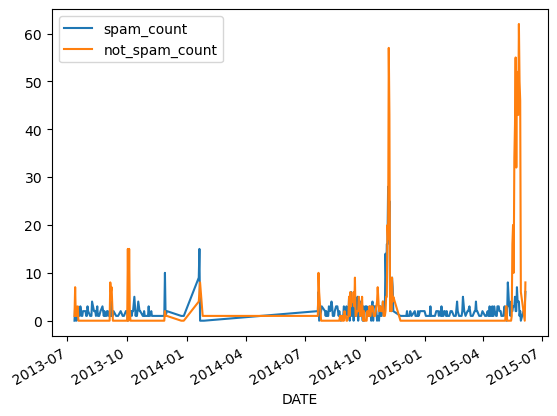

In [185]:
# Spam and not spam overtime

# Create new view with grouped by date
df_date_and_spam = df.dropna()["DATE"].dt.normalize().to_frame().join(df["CLASS"])

df_counts = df_date_and_spam.value_counts().reset_index()
df_counts = df_counts.sort_values("DATE", ascending=True)

# Create new columns based on CLASS and then drop CLASS and count
df_counts["spam_count"] = df_counts["count"].where(df_counts["CLASS"] == 1, other=0)
df_counts["not_spam_count"] = df_counts["count"].where(df_counts["CLASS"] == 0, other=0)
df_counts = df_counts.drop(["CLASS", "count"], axis=1)

# Merge two rows by adding them
df_counts = df_counts.groupby("DATE").sum().reset_index()

ax = df_counts.plot(x="DATE", y=["spam_count", "not_spam_count"])

Looks like from the plot the focus of the collected data is from 2013 to 2015, which means that it's possible spammers have changed their strategy on how they spam. Also, I suspect that the data is heavily focused on certain video releases.

<Axes: xlabel='VIDEO_NAME'>

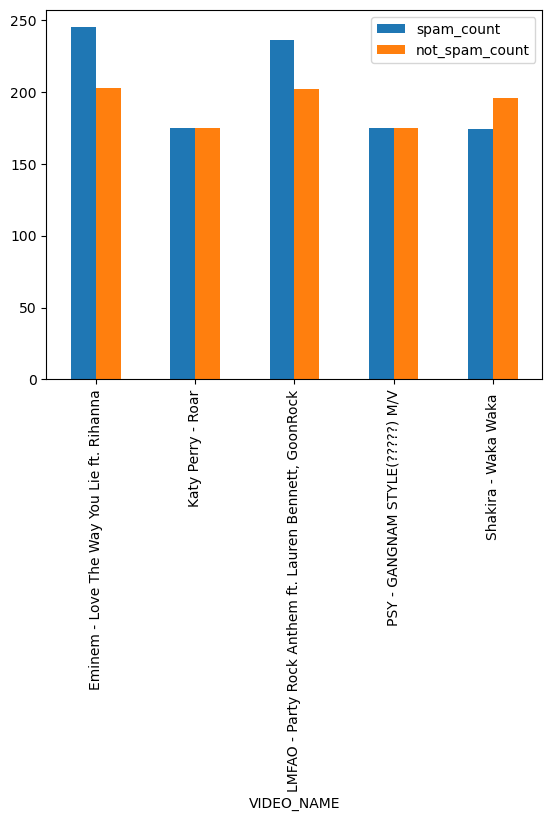

In [186]:
# Spam per video

# Create new view with grouped by date
df_video_name_and_spam = df["VIDEO_NAME"].to_frame().join(df["CLASS"])

df_counts = df_video_name_and_spam.value_counts().reset_index()
df_counts = df_counts.sort_values("VIDEO_NAME", ascending=True)

# Create new columns based on CLASS and then drop CLASS and count
df_counts["spam_count"] = df_counts["count"].where(df_counts["CLASS"] == 1, other=0)
df_counts["not_spam_count"] = df_counts["count"].where(df_counts["CLASS"] == 0, other=0)
df_counts = df_counts.drop(["CLASS", "count"], axis=1)

# Merge two rows by adding them
df_counts = df_counts.groupby("VIDEO_NAME").sum().reset_index()

df_counts.plot(x="VIDEO_NAME", y=["spam_count", "not_spam_count"], kind="bar")

Pretty even distribution between spam and not spam for each of the videos.

### String normalization
First have to cleanup and simplify the "CONTENT" to be able to feed it into a SVM since as it stands now with some special characters the "CONTENT" is too complex.
A good tutorial followed is here: https://www.kaggle.com/code/mehmetlaudatekman/tutorial-word-embeddings-with-svm/notebook

Removing special characters, except for single quote and replacing them with spaces.





In [187]:
# lowercase and replace string with spaces
df["CONTENT"] = df["CONTENT"].apply(lambda x: re.sub("[^a-z0-9']", " ", x.lower()))
df["AUTHOR"] = df["AUTHOR"].apply(lambda x: re.sub("[^a-z0-9']", " ", x.lower()))
df.head()

,AUTHOR,DATE,CONTENT,VIDEO_NAME,CLASS
0,julius nm,2013-11-07 06:20:48,huh anyway check out this you tube channel ...,PSY - GANGNAM STYLE(?????) M/V,1
1,adam riyati,2013-11-07 12:37:15,hey guys check out my new channel and our firs...,PSY - GANGNAM STYLE(?????) M/V,1
2,evgeny murashkin,2013-11-08 17:34:21,just for test i have to say murdev com,PSY - GANGNAM STYLE(?????) M/V,1
3,elnino melendez,2013-11-09 08:28:43,me shaking my sexy ass on my channel enjoy,PSY - GANGNAM STYLE(?????) M/V,1
4,gsmega,2013-11-10 16:05:38,watch v vtarggvgtwq check this out,PSY - GANGNAM STYLE(?????) M/V,1


### String Tokenization and Word2Vec Model
Leveraging word embeddings, which essentially converts the word to numbers.
This is first done by splitting each sentence to its component words and then creating a Word2Vec model from gensim package which is trained on the words in the dataset, this will connect words and provide a way to see how similar words are from one another.


In [188]:
# Create list of each entry being the component words split into a list
content_tokens = [[word for word in entry.split() if word != ""] for entry in df["CONTENT"]]

# Setting word vector size to 200
vector_size = 200

# Train Word2Vec model
content_model = gensim.models.Word2Vec(content_tokens, vector_size=vector_size)

print("Content model word similar to you", content_model.wv.most_similar("you"))

Content model word similar to you [('so', 0.999721348285675), ('to', 0.9996957778930664), ('more', 0.9996945858001709), ('will', 0.999685525894165), ('it', 0.9996849298477173), ('do', 0.9996788501739502), ('can', 0.9996725916862488), ('but', 0.9996715188026428), ('that', 0.9996680021286011), ('see', 0.9996678829193115)]


Convert each word sequence to a vector

In [189]:
# Creating embedding sequences

# Length of each sentence to look at
sequence_length = 15

# Most common word to look at
max_words = 1500

# All tokens from input set
all_tokens = set(np.concatenate(content_tokens).ravel())

# Helper function to extra vector from provided block of text
def text_to_vector(text: str):
    vectors = []
    tokens = text.lower().split()
    for i in range(sequence_length):
        if i < len(tokens) and tokens[i] in content_model.wv:
            vectors.append(content_model.wv[tokens[i]])
        else:
            vectors.append(np.zeros(vector_size,))
    return np.asarray(vectors).flatten()
            
test_vector = text_to_vector("Love is something")
print("Test vector:", test_vector)
print("vector shape:", test_vector.shape)

Test vector: [-0.09046714 -0.03845366  0.03232839 ...  0.          0.
  0.        ]
vector shape: (3000,)


### PCA Dimensionality Reduction
It's not feasible to train or use a model that uses a vector with 3000 features on commodity hardware. A common way to simplify this as pointed out by the tutorial is to use PCA (Principal Component Analysis). This works by reducing the dimension of the data.


In [190]:
# Compute all content vectors and store as numpy array
content_vectors = np.asarray([text_to_vector(content) for content in df["CONTENT"]])
print("Content vector shape", content_vectors.shape)

from sklearn.decomposition import PCA

pca_model = PCA(n_components=100)
pca_model.fit(content_vectors)
print("Sum of variance ratios:", sum(pca_model.explained_variance_ratio_))

Content vector shape (1956, 3000)
Sum of variance ratios: 0.9993554603392899


The variance shows that the original data is preserved quiet well.

In [191]:
# Transforming the vectors after showing that the model fit quiet well.
content_components = pca_model.transform(content_vectors)
print("Content Components shape:", content_components.shape)

Content Components shape: (1956, 100)


Now there are only 100 components instead of the original 3000.

### Training SVM Model


In [192]:
x_train,x_test,y_train,y_test = train_test_split(content_components, df["CLASS"], test_size=0.2)
print("X Train Shape", x_train.shape)
print("X Test Shape", x_test.shape)
print("Y Train Shape", y_train.shape)
print("Y Test Shape",y_test.shape)

X Train Shape (1564, 100)
X Test Shape (392, 100)
Y Train Shape (1564,)
Y Test Shape (392,)


In [193]:
svm = SVC()
svm.fit(x_train,y_train)
svm.score(x_test, y_test)

0.7346938775510204

A score of .744 isn't too good with classification, only marginally above random which would be expected to be around .50.

Trying some tuning since it's possible the C value is too low and the data is overly fit. Trying multiple configurations.

In [194]:
from sklearn.model_selection import GridSearchCV

# Grid search with various C and gamma values
grid=GridSearchCV(SVC(), {"C": np.logspace(-5, 5,  11, base=2), 
                        "gamma": np.logspace(-5, 5, 11, base=2)},
                 cv=3, n_jobs=-1)
grid.fit(x_train,y_train)
print("Best params", grid.best_params_)
print("Best score", grid.best_score_)

Best params {'C': 32.0, 'gamma': 0.03125}
Best score 0.7864505580436484


Initial glance shows increasing C seems to help and keeping gamma low which would track with the variance of the data.

In [195]:
# Trying again this time just changing C
# Grid search with various C and gamma values
grid=GridSearchCV(SVC(), {"C": np.logspace(-5, 32, base=2)},
                 cv=3, n_jobs=-1)
grid.fit(x_train,y_train)
print("Best params", grid.best_params_)
print("Best score", grid.best_score_)

print("Test best score", grid.best_estimator_.score(x_test, y_test))

Best params {'C': 15050.78401549067}
Best score 0.7979595188543498
Test best score 0.8214285714285714


Was only able so squeeze out a little more accuracy, let's see how it behaves with other models like the random forest and logistic regression. A nice benefit of increasing the C value it resulted in the data not being overly fit to the training data nad resulted in a reasonable score increase when looking at the test set of data.

In [196]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

# Random forest classifier
rfc = RandomForestClassifier()
rfc.fit(x_train, y_train)
print("Score of RandomForestClassifier", rfc.score(x_test,y_test))

# Logistic Regression
logreg = LogisticRegression()
logreg.fit(x_train, y_train)
print("Score of LogisticRegression", logreg.score(x_test,y_test))



Score of RandomForestClassifier 0.8954081632653061
Score of LogisticRegression 0.8061224489795918


The Random Forest Classifier did surprisingly well and would make sense intuitively because it would "read" the sentence and then decide based different decision trees which comment is SPAM. A score of almost .90 is very good score.

# Conclusion

Despite going into this not knowing how to convert a string field into something usable for the models it was interesting to learn about PCA and Word2Vec. Despite having other features that were usable, I ultimately decided to not use them for generating the model because names used on platforms like YouTube can be too inconsistent or made up to be reliable. 

Some things that can be improved would be to use a larger dataset, this one was large enough to learn but lacked some of the value provided by a larger model and the model was taken from an older dataset.

In the day and age of large language models, it's nice to see the value of the "simpler" models like SVM that is still capable to get things done. In the later classes I hope to be able to revisit the dataset to apply learned skills to make better predictions and better data cleaning.